In [26]:
import pandas as pd
import numpy as np
import time
import csv
import math
import os
import matplotlib as mpl
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.animation import writers

%matplotlib notebook

In [27]:
def normalize(x):
    max= 0.0
    for i in range(len(x)):
        if abs(x[i]) > max:
            max = abs(x[i])
    for i in range(len(x)):
        x[i] /= max
    return x

In [28]:
def spectrum(Vib_Freq, observable, fwhm, num_points, spectro):
    max_freq = 0.49593677
    min_freq = 0
    delta = float((max_freq-min_freq)/num_points)
    Vib_Freq_axis = np.arange(min_freq, max_freq, delta)
    Vib_Freq_axis_cm1 = Vib_Freq_axis*8065.54429
    spec = np.zeros_like(Vib_Freq_axis)
    if spectro == 'ROA':
        peak_pos = peak_finder(observable, Vib_Freq)
        for j in range(len(peak_pos)):
            spec += observable[j]/(1+(2*(Vib_Freq_axis-peak_pos[j])/fwhm)**2)
    else:
        for j in range(len(Vib_Freq)):
            spec += (1/((2.296*10**(-39))*np.sqrt(np.pi)*fwhm))*Vib_Freq[j]*observable[j]*np.exp(-((Vib_Freq_axis-Vib_Freq[j])/fwhm)**2)
    return normalize(spec), Vib_Freq_axis_cm1


In [29]:
def peak_finder(CID3, Vib_Freq):
    peak_pos = []
    peaks, _ = find_peaks(CID3)
    for i in range(len(peaks)):
        temp = peaks[i]
        peak_pos.append(Vib_Freq[temp])
    return np.array(peak_pos)

In [30]:
spectro = input("Enter the spectroscopy method used : ")
t1 = time.time()

df = pd.read_csv("Sorted.txt", header=None, delimiter='\t')
combined = df[[2,3]].to_numpy()
Vib_Freq = combined[:,0]
observable = combined[:,1]

df = pd.read_csv("Combined_Free_Energy.txt", header=None, delimiter='\t')
combined = df[[0,1]].to_numpy()
cmpd2 = combined[:,0]

num_points = 2000
fwhm = 0.008

ROA_conv, Vib_Freq_axis_conv = spectrum(Vib_Freq, observable, fwhm, num_points, spectro)

t2 = time.time()
print(t2-t1)

Enter the spectroscopy method used : ROA
0.3214139938354492


In [31]:
#snapshot averaged spectrum
t1 = time.time()

X = []
Y = []

snaps = []

#params
num_points = 2000
fwhm = 0.008
tot_snapshots = len(cmpd2)
step_size = 5

for snap in range(step_size, tot_snapshots+1, step_size):
    print("Collecting data for snapshots till : ", snap)
    snaps.append(snap)
    # read in the file as a DataFrame
    df = pd.read_csv('Sorted.txt', header=None, delimiter='\t')

    # get the rows with conformer_number up to a certain value
    df[0] = df[0].astype(int)
    df = df.loc[df[0] <= snap]

    # extract the Vib_Freq and CID3 columns as a numpy array
    vib_freq_cid3 = df[[2, 3]].to_numpy()
    Vib_Freq3 = vib_freq_cid3[:,0]
    observable3 = vib_freq_cid3[:,1]
    
    spec,freq = spectrum(Vib_Freq3, observable3, fwhm, num_points, spectro)
    X.append(freq)
    Y.append(spec)
    
t2 = time.time()
print(t2-t1)

2.1202311515808105


<IPython.core.display.Javascript object>


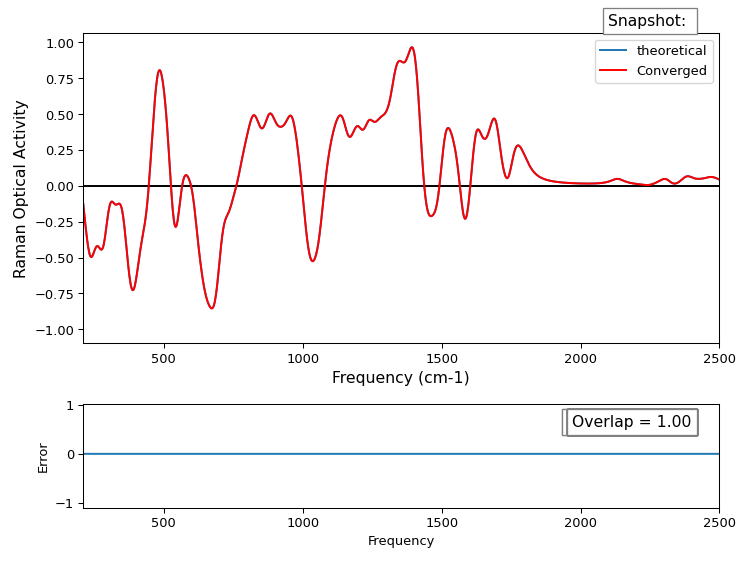

In [32]:
# Create the figure and axes
plt.rcParams["figure.figsize"] = [8,6]
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
#axs = fig.add_subplot(111)
line1, = ax1.plot(X[0], normalize(Y[0]), label="theoretical")
freq_exp = np.array(Vib_Freq_axis_conv)
spec_exp = np.array(normalize(ROA_conv))
line2, = ax2.plot(X[0], normalize(Y[0]), label="Error")
ax1.set_xlim(210,2500)
ax2.set_xlim(210,2500)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Error')

ax1.set_xlabel('Frequency (cm-1)', fontsize=12)
ax1.set_ylabel('Raman Optical Activity', fontsize=12)
ax1.axhline(y = 0, color = 'black')
snapshot = ax1.text(2400, 1.2, '', ha='right', va='top', fontsize=12,bbox=dict(facecolor='white', edgecolor='gray'))

# Define the number of frames to be the length of E
num_frames = len(Y)
ax1.plot(Vib_Freq_axis_conv, ROA_conv, color="red", label="Converged")
ax1.legend()



overlap_list = []
# Define the animation function to update the y-data of line0 and snapshot
def animate(i):
    line1.set_ydata(normalize(Y[i]))
    line1.set_xdata(X[i])

    freq_theory = np.array(X[i])
    spec_theory = np.array(normalize(Y[i]))
    error = spec_exp - spec_theory
    # Calculate the overlap
    overlap = np.trapz(spec_exp*spec_theory, freq_exp)
    deno1 = np.trapz(spec_exp*spec_exp, freq_exp)
    deno2 = np.trapz(spec_theory*spec_theory, freq_exp)
    deno = np.sqrt(deno1*deno2)
    overlap /= deno
    
    overlap_list.append(overlap)
    flag = (i+1)*5
    snapshot.set_text('Snapshot: ')
    # Plot the error spectrum on the lower axes
    line2.set_ydata(error)
    line2.set_xdata(freq_exp)
    #line2 = ax2.plot(freq_exp, error, label='Error')
    # Plot the overlap as a text box
    ax2.text(2400, 0.8, 'Overlap = %.2f' % overlap, ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='gray'))
    area = np.trapz(error, x=freq_exp)

    # Add the shaded area to the error plot
    #ax2.fill_between(freq_exp, error, alpha=0.2, color='blue')
    
    #ax2.set_xlim(2200,3000)
    #ax2.legend()
    return line1,line2,snapshot
    

# Plotting dynamic spectrum
ani = anim.FuncAnimation(
    fig, animate, frames=num_frames, interval=1000,repeat=False)

plt.show()

In [33]:
overlap_list

[-0.04965213971162893,
 -0.04965213971162893,
 0.0030943025768838638,
 0.15683825920039796,
 0.1778171906337267,
 0.2424843834674209,
 0.1874899724962776,
 0.3798293341056897,
 0.3762003650625126,
 0.4926904333905522,
 0.5889626570047376,
 0.5903584960576885,
 0.6577767657070934,
 0.6464237944107946,
 0.6478417572576619,
 0.7021090987184226,
 0.733548767727073,
 0.8111485093965511,
 0.7688838669608229,
 0.9065541011989283,
 1.0]

<IPython.core.display.Javascript object>


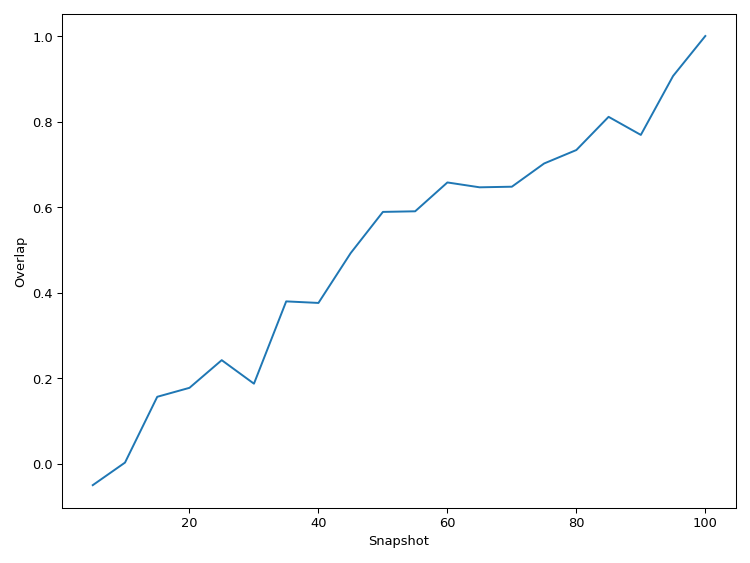

In [34]:
fog, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["figure.autolayout"] = True

plt.plot(snaps, overlap_list[1:])

plt.xlabel("Snapshot")
plt.ylabel("Overlap")


#plt.xlim(2700,3300)

plt.show()

21